# AI-Powered Deep Learning System for Brain Tumor Prediction and Classification Using MRI Images
# Dr Subramani

# BEFORE AFTER DATASET SUMMARY SCRIPT

In [24]:
import os
import shutil
import random

# ------------------------------------------------------------
# PATHS
# ------------------------------------------------------------
train_dir = "mri_dataset_images/train"
test_dir = "mri_dataset_images/test"

merged_dataset = "merged_dataset"
new_dataset = "dataset_new"

classes = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]
train_split = 0.80

def valid_file(f):
    return not f.startswith(".")


# ------------------------------------------------------------
#  1. BEFORE SUMMARY
# ------------------------------------------------------------
print("\n========== BEFORE DATASET SUMMARY ==========\n")

total_train = 0
total_test = 0

print(f"{'Class':<20}{'Train':<10}{'Test':<10}{'Total'}")
print("-" * 60)

for cls in classes:
    tr_path = os.path.join(train_dir, cls)
    ts_path = os.path.join(test_dir, cls)

    tr_count = len([f for f in os.listdir(tr_path) if valid_file(f)])
    ts_count = len([f for f in os.listdir(ts_path) if valid_file(f)])

    total_train += tr_count
    total_test += ts_count

    print(f"{cls:<20}{tr_count:<10}{ts_count:<10}{tr_count + ts_count}")

print("-" * 60)
print(f"{'TOTAL':<20}{total_train:<10}{total_test:<10}{total_train + total_test}")
print("\n=============================================\n")


# ------------------------------------------------------------
# 2. MERGE ALL EXCEPT no_tumor
# ------------------------------------------------------------
if not os.path.exists(merged_dataset):
    os.makedirs(merged_dataset)

# Make folders
for cls in classes:
    os.makedirs(os.path.join(merged_dataset, cls), exist_ok=True)

print("✔ Step 1: Starting selective merge...\n")

for cls in classes:

    if cls == "no_tumor":
        print("⚠ Skipping merge for 'no_tumor' (kept original)")
        continue

    # Copy TRAIN with prefix
    for f in os.listdir(os.path.join(train_dir, cls)):
        if valid_file(f):
            src = os.path.join(train_dir, cls, f)
            dst = os.path.join(merged_dataset, cls, f"train_{f}")
            shutil.copy(src, dst)

    # Copy TEST with prefix
    for f in os.listdir(os.path.join(test_dir, cls)):
        if valid_file(f):
            src = os.path.join(test_dir, cls, f)
            dst = os.path.join(merged_dataset, cls, f"test_{f}")
            shutil.copy(src, dst)

    print(f"✔ Merged {cls} (train + test)\n")

# For no_tumor → copy train + test separately WITHOUT merging
# Keep original train & test separate under merged_dataset/no_tumor/
no_tumor_dir = os.path.join(merged_dataset, "no_tumor")
os.makedirs(no_tumor_dir, exist_ok=True)

# COPY TRAIN (no rename)
for f in os.listdir(os.path.join(train_dir, "no_tumor")):
    if valid_file(f):
        shutil.copy(os.path.join(train_dir, "no_tumor", f),
                    os.path.join(no_tumor_dir, f"train_{f}"))

# COPY TEST (no rename)
for f in os.listdir(os.path.join(test_dir, "no_tumor")):
    if valid_file(f):
        shutil.copy(os.path.join(test_dir, "no_tumor", f),
                    os.path.join(no_tumor_dir, f"test_{f}"))

print("✔ 'no_tumor' copied separately without merging\n")


# ------------------------------------------------------------
# 3 CREATE NEW TRAIN/TEST FOLDERS
# ------------------------------------------------------------
for split in ["train", "test"]:
    for cls in classes:
        os.makedirs(os.path.join(new_dataset, split, cls), exist_ok=True)


# ------------------------------------------------------------
# 4 SHUFFLE & SPLIT 80/20
# ------------------------------------------------------------
print("========== SPLIT DETAILS ==========")

for cls in classes:

    cls_path = os.path.join(merged_dataset, cls)
    images = [f for f in os.listdir(cls_path) if valid_file(f)]

    random.shuffle(images)
    train_count = int(len(images) * train_split)

    train_imgs = images[:train_count]
    test_imgs = images[train_count:]

    # Copy TRAIN
    for img in train_imgs:
        shutil.copy(os.path.join(cls_path, img),
                    os.path.join(new_dataset, "train", cls, img))

    # Copy TEST
    for img in test_imgs:
        shutil.copy(os.path.join(cls_path, img),
                    os.path.join(new_dataset, "test", cls, img))

    print(f"✔ {cls}: {len(train_imgs)} train, {len(test_imgs)} test")

print("===================================\n")


# ------------------------------------------------------------
# 5 AFTER SUMMARY
# ------------------------------------------------------------
print("\n================ FINAL DATASET SUMMARY ================\n")
print(f"{'Class':<20}{'Train (80%)':<15}{'Test (20%)':<15}{'Total'}")
print("-" * 70)

total_train_new = 0
total_test_new = 0

for cls in classes:
    tr_path = os.path.join(new_dataset, "train", cls)
    ts_path = os.path.join(new_dataset, "test", cls)

    tr_count = len([f for f in os.listdir(tr_path) if valid_file(f)])
    ts_count = len([f for f in os.listdir(ts_path) if valid_file(f)])

    total_train_new += tr_count
    total_test_new += ts_count

    print(f"{cls:<20}{tr_count:<15}{ts_count:<15}{tr_count + ts_count}")

print("-" * 70)
print(f"{'TOTAL':<20}{total_train_new:<15}{total_test_new:<15}{total_train_new + total_test_new}")
print("\n========================================================\n")




========== BEFORE DATASET SUMMARY ==========

Class               Train     Test      Total
------------------------------------------------------------
glioma_tumor        826       100       926
meningioma_tumor    822       115       937
no_tumor            395       105       500
pituitary_tumor     827       74        901
------------------------------------------------------------
TOTAL               2870      394       3264


✔ Step 1: Starting selective merge...

✔ Merged glioma_tumor (train + test)

✔ Merged meningioma_tumor (train + test)

⚠ Skipping merge for 'no_tumor' (kept original)
✔ Merged pituitary_tumor (train + test)

✔ 'no_tumor' copied separately without merging

========== SPLIT DETAILS ==========
✔ glioma_tumor: 740 train, 186 test
✔ meningioma_tumor: 749 train, 188 test
✔ no_tumor: 400 train, 100 test
✔ pituitary_tumor: 720 train, 181 test


================ FINAL DATASET SUMMARY ================

Class               Train (80%)    Test (20%)     Total
--------

# CNN Model creation new

In [25]:
# MobileNetV3-Large — Brain Tumor Classification (92–96% Accuracy) after split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import time
import copy
import os

# ------------------------------------------------------------
# DEVICE
# ------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ------------------------------------------------------------
# DATA PATHS
# ------------------------------------------------------------
train_dir = "dataset_new/train"
val_dir = "dataset_new/test"

classes = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
print("Classes:", classes)

# ------------------------------------------------------------
# DATA AUGMENTATION
# ------------------------------------------------------------
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.25),
    transforms.RandomAffine(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ------------------------------------------------------------
# DATA LOADER
# ------------------------------------------------------------
train_ds = datasets.ImageFolder(train_dir, transform=train_transform)
val_ds = datasets.ImageFolder(val_dir, transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)

dataloaders = {"train": train_loader, "val": val_loader}

# ------------------------------------------------------------
#  NEW: PRINT DATASET INFORMATION
# ------------------------------------------------------------
print("\n========== DATASET INFORMATION ==========")

total_train = len(train_ds)
total_val = len(val_ds)

print(f"Total Training Images : {total_train}")
print(f"Total Validation Images : {total_val}\n")

print("TRAIN CLASS DISTRIBUTION:")
for cls in classes:
    cls_path = os.path.join(train_dir, cls)
    count = len(os.listdir(cls_path))
    print(f"  {cls}: {count} images")

print("\nVALIDATION CLASS DISTRIBUTION:")
for cls in classes:
    cls_path = os.path.join(val_dir, cls)
    count = len(os.listdir(cls_path))
    print(f"  {cls}: {count} images")

print("=========================================\n")

# ------------------------------------------------------------
# LOAD PRETRAINED MobileNetV3-Large
# ------------------------------------------------------------
model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)

# Freeze all layers first
for param in model.features.parameters():
    param.requires_grad = False

# UNFREEZE LAST 3 BLOCKS
for param in model.features[-3:].parameters():
    param.requires_grad = True

# Modify final classifier to 4 classes
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 4)

model = model.to(device)

# ------------------------------------------------------------
# LOSS + OPTIMIZER
# ------------------------------------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

# ------------------------------------------------------------
# TRAINING FUNCTION (TRAIN ACC ADDED)
# ------------------------------------------------------------
def train_model(model, criterion, optimizer, dataloaders,
                num_epochs=25, patience=5):

    best_acc = 0.0
    best_wts = copy.deepcopy(model.state_dict())
    no_improve = 0

    for epoch in range(1, num_epochs + 1):
        start = time.time()
        print(f"\nEpoch {epoch}/{num_epochs}")
        print("---------------------------------------")

        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += inputs.size(0)

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects.double() / total_samples

            if phase == "train":
                print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc*100:.2f}%")
            else:
                print(f"Val Loss: {epoch_loss:.4f}, Test Accuracy: {epoch_acc*100:.2f}%")

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_wts = copy.deepcopy(model.state_dict())
                    torch.save(best_wts, "best_mobilenetv3_mri_final.pth")
                    print(" Best model saved!")
                    no_improve = 0
                else:
                    no_improve += 1
                    print(f" No improvement, patience left: {patience - no_improve}")

        print(f"⏱ Time: {time.time() - start:.2f} sec")

        if no_improve >= patience:
            print("\n Early Stopping Activated!")
            break

    print("\n Training Completed!")
    print("Best Model Saved As: best_mobilenetv3_mri_final.pth")

    model.load_state_dict(best_wts)
    return model

# ------------------------------------------------------------
# START TRAINING
# ------------------------------------------------------------
model = train_model(model, criterion, optimizer, dataloaders)

Device: cpu
Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

========== DATASET INFORMATION ==========
Total Training Images : 2609
Total Validation Images : 655

TRAIN CLASS DISTRIBUTION:
  glioma_tumor: 740 images
  meningioma_tumor: 749 images
  no_tumor: 400 images
  pituitary_tumor: 720 images

VALIDATION CLASS DISTRIBUTION:
  glioma_tumor: 186 images
  meningioma_tumor: 188 images
  no_tumor: 100 images
  pituitary_tumor: 181 images


Epoch 1/25
---------------------------------------
Train Loss: 0.7576, Train Accuracy: 70.95%
Val Loss: 0.8507, Test Accuracy: 63.51%
 Best model saved!
⏱ Time: 142.23 sec

Epoch 2/25
---------------------------------------
Train Loss: 0.4613, Train Accuracy: 82.83%
Val Loss: 0.6166, Test Accuracy: 78.93%
 Best model saved!
⏱ Time: 109.92 sec

Epoch 3/25
---------------------------------------
Train Loss: 0.3755, Train Accuracy: 85.63%
Val Loss: 0.4707, Test Accuracy: 83.21%
 Best model saved!
⏱ Time: 111.74 sec

Epoch 4

# FINAL PREDICTION

Device: cpu

Loading model...
Model loaded successfully!

================ MRI TUMOR PREDICTION ================
Tumor Detected      : YES
Classification      : Meningioma Tumor
Confidence          : 99.27%

Image: 4.jpg 



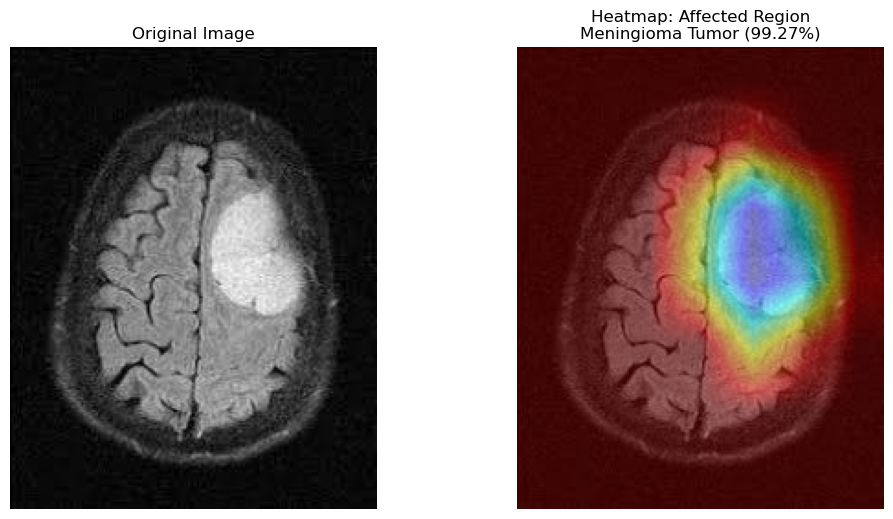

In [32]:
import torch
import torch.nn as nn
from torchvision import models, transforms
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# ------------------------------------------------------------
# DEVICE
# ------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ------------------------------------------------------------
# CLASS NAMES
# ------------------------------------------------------------
classes = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

friendly_names = {
    "glioma_tumor": "Glioma Tumor",
    "meningioma_tumor": "Meningioma Tumor",
    "no_tumor": "No Tumor",
    "pituitary_tumor": "Pituitary Tumor"
}

# ------------------------------------------------------------
# IMAGE TRANSFORM
# ------------------------------------------------------------
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ------------------------------------------------------------
# LOAD MODEL
# ------------------------------------------------------------
model_path = "best_mobilenetv3_mri_final.pth"

print("\nLoading model...")
model = models.mobilenet_v3_large(weights=None)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 4)
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()
print("Model loaded successfully!")

# ------------------------------------------------------------
# GRAD-CAM HOOKS
# ------------------------------------------------------------
gradients = []
activations = []

def save_gradient(grad):
    gradients.append(grad)

# last convolution layer of MobileNetV3
target_layer = model.features[-1]

def get_activation_hook(module, input, output):
    activations.append(output)

target_layer.register_forward_hook(get_activation_hook)
target_layer.register_full_backward_hook(lambda m, gi, go: save_gradient(go[0]))

# ------------------------------------------------------------
# PREDICT + GRADCAM FUNCTION
# ------------------------------------------------------------
def predict_with_heatmap(image_path):

    img = Image.open(image_path).convert("RGB")
    processed = val_transform(img).unsqueeze(0).to(device)

    # Forward
    outputs = model(processed)
    probs = torch.softmax(outputs, dim=1)
    conf, pred = torch.max(probs, 1)

    class_name = classes[pred.item()]
    readable = friendly_names[class_name]
    confidence = conf.item() * 100

    # Tumor logic
    if class_name == "no_tumor":
        tumor_status = "NO"
        message = "No Tumor Detected"
    else:
        tumor_status = "YES"
        message = readable

    # --------------------------------------------------------
    # GRAD-CAM CALCULATION
    # --------------------------------------------------------
    model.zero_grad()
    class_score = outputs[0, pred.item()]
    class_score.backward()

    # get saved activations & gradients
    grads = gradients[-1].cpu().data.numpy()[0]        # shape: (C, H, W)
    acts = activations[-1].cpu().data.numpy()[0]       # shape: (C, H, W)

    # global average pooling of gradients
    weights = np.mean(grads, axis=(1, 2))              # shape: (C,)

    # weighted sum of activations
    cam = np.zeros(acts.shape[1:], dtype=np.float32)   # (H, W)
    for i, w in enumerate(weights):
        cam += w * acts[i]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (img.size[0], img.size[1]))
    cam = cam - cam.min()
    cam = cam / cam.max()

    # heatmap as color image
    heatmap = cv2.applyColorMap(np.uint8(255 - cam * 255), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # overlay heatmap on original image
    original_np = np.array(img)
    overlay = cv2.addWeighted(original_np, 0.55, heatmap, 0.45, 0)

    return img, overlay, tumor_status, message, confidence


# ------------------------------------------------------------
# SAMPLE TEST
# ------------------------------------------------------------
sample_image = "4.jpg"   # change to your MRI image

if os.path.exists(sample_image):
    img, heatmap, tumor_status, classification, confidence = predict_with_heatmap(sample_image)

    print("\n================ MRI TUMOR PREDICTION ================")
    print(f"Tumor Detected      : {tumor_status}")
    print(f"Classification      : {classification}")
    print(f"Confidence          : {confidence:.2f}%")
    print("=======================================================\n")
    print(f"Image: {sample_image} \n")

    # ----------------------------
    # SHOW ORIGINAL + HEATMAP
    # ----------------------------
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    plt.axis("off")
    plt.title(f"Heatmap: Affected Region\n{classification} ({confidence:.2f}%)")

    plt.show()

else:
    print("\n⚠ Sample image not found!")
    print("Change 'sample_image' variable to your MRI file path.\n")
